In this notebook, useful data loading and transforming functions are demonstrated.  The main sources of data are Quandl, Cryptocompare and Yahoo Finance.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import os
import re
import dill as pickle
import itertools
from tqdm import tqdm, tqdm_notebook
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 6)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

import quandl

In [52]:
from utils import *

# Quandl

In [ ]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key

## Exchange Data International

One may use [_Exchange Data International_](https://www.quandl.com/publishers/edi) free sample series as follows:

In [ ]:
print(os.listdir(QUANDL_PATH + 'EDI/'))

In [ ]:
# tickers, prices = get_quandl_edi(get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys())), download=True)  # The first time...
tickers, prices = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))

In [ ]:
prices

In [ ]:
print('Number of price series:', len(tickers))

In [ ]:
j = np.random.choice(len(tickers) - 1)
ticker_j = list(tickers)[j]
print('j:', j, ' - ', ticker_j)
price_j = prices.loc[ticker_j]
price_j[['Open', 'High', 'Low', 'Close']].plot();

In [ ]:
price_j

##  Sharadar Equity Prices

One may use [_Sharadar Equity Prices_](https://www.quandl.com/publishers/sharadar) free sample series as follows:

In [ ]:
# tickers, prices = get_quandl_sharadar(download=True)  # The first time...
tickers, prices = get_quandl_sharadar(free=False)

In [ ]:
print('Number of price series:', len(tickers))

In [ ]:
prices

In [ ]:
j = np.random.choice(len(tickers) - 1)
ticker_j = list(tickers)[j]
print('j:', j, ' - ', ticker_j)
price_j = prices.loc[ticker_j]
price_j[['Open', 'High', 'Low', 'Close']].plot()
plt.axhline(c='grey')
plt.show()

In [ ]:
price_j

### Metadata...

In [ ]:
shr_meta = pd.read_csv(QUANDL_PATH + 'Sharadar/SHARADAR-TICKERS.csv')
shr_meta.to_excel(QUANDL_PATH + 'Sharadar/SHARADAR-TICKERS.xlsx')
shr_meta.keys()

In [ ]:
shr_meta.describe(include=np.object)

In [ ]:
shr_meta.groupby('currency').count()

### Train, Dev, Test samples 

In [ ]:
p_train = 0.7
p_dev = 0.15

In [ ]:
N = len(tickers)
train, dev = round(p_train * N), round(p_dev * N)
test = N - train - dev
print('N:', N, ', Tain:', train, ', Dev:', dev, ', Test:', test)

In [ ]:
np.random.seed(123)
tickers_full = list(np.random.permutation(tickers))
tickers_train = tickers_full[:train]
tickers_dev = tickers_full[train:(train + dev)]
tickers_test = tickers_full[-test:]
assert len(tickers_train + tickers_dev + tickers_test) == N

In [ ]:
tickers_in_train_folder = [f.replace('.feather', '') for f in os.listdir(QUANDL_PATH + 'Sharadar/train/')]
set(tickers_train) == set(tickers_in_train_folder)

In [ ]:
# # Only run once
# for t in tickers_train:
#     prices.loc[t].reset_index().to_feather(fname=QUANDL_PATH + 'Sharadar/train/' + t + '.feather')

In [ ]:
# # Only run once
# for t in tickers_dev:
#     prices.loc[t].reset_index().to_feather(fname=QUANDL_PATH + 'Sharadar/dev/' + t + '.feather')

In [ ]:
# # Only run once
# for t in tickers_test:
#     prices.loc[t].reset_index().to_feather(fname=QUANDL_PATH + 'Sharadar/test/' + t + '.feather')

In [ ]:
dir_train = os.listdir(QUANDL_PATH + 'Sharadar/train/')
tickers_train = [f.replace('.feather', '') for f in dir_train]
train_files = [QUANDL_PATH + 'Sharadar/train/' + f for f in dir_train]
prices_train = pd.read_feather(train_files[0]).assign(Ticker=tickers_train[0])

for i in tqdm_notebook(range(1, len(tickers_train))):
    df_i = pd.read_feather(train_files[i]).assign(Ticker=tickers_train[i])
    prices_train = pd.concat((prices_train, df_i), axis=0)

In [ ]:
def select_train_dev_test(x, ptr=0.7, pdv=0.15, pts=0.15):
    y = ['train'] * int(len(x) * ptr) + ['dev'] * int(len(x) * pdv)
    y += ['test'] * (len(x) - len(y))
    return(y)

prices_train = prices_train.sort_values(['Ticker', 'Date'])
prices_train = prices_train.assign(Set=np.nan)
prices_train['Set'] = prices_train.groupby(prices_train['Ticker'], sort=False).transform(select_train_dev_test)
prices_train = prices_train.reset_index().drop('index', axis=1)
prices_train.to_feather(fname=QUANDL_PATH + 'Sharadar/sharadar_train.feather')

In [ ]:
dir_dev = os.listdir(QUANDL_PATH + 'Sharadar/dev/')
tickers_dev = [f.replace('.feather', '') for f in dir_dev]
dev_files = [QUANDL_PATH + 'Sharadar/dev/' + f for f in dir_dev]
prices_dev = pd.read_feather(dev_files[0]).assign(Ticker=tickers_dev[0])

for i in tqdm_notebook(range(1, len(tickers_dev))):
    df_i = pd.read_feather(dev_files[i]).assign(Ticker=tickers_dev[i])
    prices_dev = pd.concat((prices_dev, df_i), axis=0)

prices_dev = prices_dev.reset_index().drop('index', axis=1)
prices_dev.to_feather(fname=QUANDL_PATH + 'Sharadar/sharadar_dev.feather')

In [ ]:
dir_test = os.listdir(QUANDL_PATH + 'Sharadar/test/')
tickers_test = [f.replace('.feather', '') for f in dir_test]
test_files = [QUANDL_PATH + 'Sharadar/test/' + f for f in dir_test]
prices_test = pd.read_feather(test_files[0]).assign(Ticker=tickers_test[0])

for i in tqdm_notebook(range(1, len(tickers_test))):
    df_i = pd.read_feather(test_files[i]).assign(Ticker=tickers_test[i])
    prices_test = pd.concat((prices_test, df_i), axis=0)

prices_test = prices_test.reset_index().drop('index', axis=1)
prices_test.to_feather(fname=QUANDL_PATH + 'Sharadar/sharadar_test.feather')

### Train, dev, test split within train 

In [ ]:
 t_train, p_train = get_sharadar_train()

In [ ]:
ticker = np.random.choice(t_train)
price = p_train.loc[ticker]

In [ ]:
pal = plt.get_cmap('Paired').colors
fig, ax = plt.subplots(figsize=(16, 5))
trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(price.index, 0, price.High.max(), where=(price.Set == 'train'), facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Train')
ax.fill_between(price.index, 0, price.High.max(), where=(price.Set == 'dev'), facecolor=pal[2],
                        alpha=0.25, transform=trans, label='Dev')
ax.fill_between(price.index, 0, price.High.max(), where=(price.Set == 'test'), facecolor=pal[4],
                        alpha=0.25, transform=trans, label='Test')
plt.plot(price.Close, label='Close')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

## Cryptocompare
TO DO

## Yahoo Finance
TO DO

# Data Cleaning

* Positive Volume.
* OHLC: open and close within [low, high].
* Positive prices
* Non nan.

In [64]:
from utils import *
tickers, prices = get_sharadar_train()

//anaconda/envs/trend/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
prices.query('Volume > 0', inplace=True)
prices = prices.assign(
    Low = prices[['Open', 'High', 'Low', 'Close']].apply('min', axis=1),
    High = prices[['Open', 'High', 'Low', 'Close']].apply('max', axis=1),
)
prices.query('High > 0', inplace=True)

In [8]:
prices.loc[prices.Open == 0, 'Open'] = prices.loc[prices.Open == 0, 'Close']
prices.loc[prices.Close == 0, 'Close'] = prices.loc[prices.Close == 0, 'Open']
prices.loc[np.all(prices[['Open', 'Close']] == 0, axis=1), ['Open', 'Close']] = \
    prices.loc[np.all(prices[['Open', 'Close']] == 0, axis=1), ['High', 'High']]
prices.loc[prices.Low == 0, 'Low'] = \
    prices.loc[prices.Low == 0, ['Open', 'High', 'Close']].apply('min', axis=1)

In [66]:
# plot_prices(prices.loc['WLM'][-500:])
# plot_prices(prices.loc['AGHC'][-150:])

In [7]:
prices.query('Low < 0')

,,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Set
Ticker,Date,,,,,,,,,


## Nas

In [13]:
prices.loc[prices.Open.isna(), 'Open'] = prices.loc[prices.Open.isna(), 'Close']
prices.loc[prices.Open.isna(), 'Open'] = prices.loc[prices.Open.isna(), 'High']
prices.loc[prices.Close.isna(), 'Close'] = prices.loc[prices.Close.isna(), 'Low']

## Data Transforms

### Weekly and monthly OHLC prices.

In [ ]:
weekly_j = daily_to_weekly_prices(price_j)

In [ ]:
weekly_j[['Open', 'High', 'Low', 'Close']].plot();

### Returns

See `utils.add_changes(df)`.

### Technical Indicators

* Volatility.
* Simple moving averages.
* Support and resistance.

In [54]:
from utils import *
df = pd.read_feather('input/Quandl/Sharadar/train/AAON.feather')
df = add_changes(df)
df

,Date,Open,High,Low,Close,Volume,Ch,Ch2,Ch3,Ch4,...,kurt_SMA_60,kurt_SMA_120,Support_5,Support_20,Support_60,Support_120,Resistance_5,Resistance_20,Resistance_60,Resistance_120
0,1998-12-31,0.818,0.818,0.818,0.818,32394.938,0.000000,0.000000,0.000000e+00,0.000000e+00,...,NaN,NaN,0.818,0.818,0.818,0.818,0.818,0.818,0.818,0.818
1,1999-01-04,0.867,0.900,0.867,0.867,168900.188,0.058177,0.003385,1.969001e-04,1.145499e-05,...,-1.000000,-1.000000,0.818,0.818,0.818,0.818,0.900,0.900,0.900,0.900
2,1999-01-05,0.878,0.878,0.867,0.878,103199.063,0.012608,0.000159,2.004006e-06,2.526574e-08,...,-0.257073,-0.257073,0.818,0.818,0.818,0.818,0.900,0.900,0.900,0.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4906,2018-07-05,34.600,35.250,34.350,35.250,218176.000,0.021506,0.000463,9.946983e-06,2.139218e-07,...,3.472443,3.105282,32.550,32.250,29.050,29.050,35.250,35.250,36.650,40.250
4907,2018-07-06,35.300,35.650,35.100,35.300,164903.000,0.001417,0.000002,2.847798e-09,4.036567e-12,...,3.476522,3.129036,32.839,32.250,29.050,29.050,35.650,35.650,36.650,40.250
4908,2018-07-09,35.500,35.750,35.200,35.700,175485.000,0.011268,0.000127,1.430569e-06,1.611925e-08,...,3.399689,3.144776,32.839,32.350,29.050,29.050,35.750,35.750,36.650,40.250


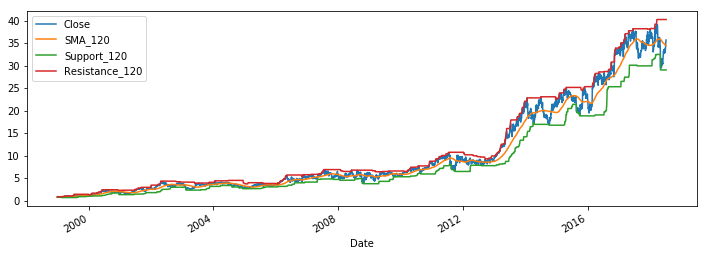

In [55]:
add_technical(df).set_index('Date')[['Close', 'SMA_120', 'Support_120', 'Resistance_120']].plot()

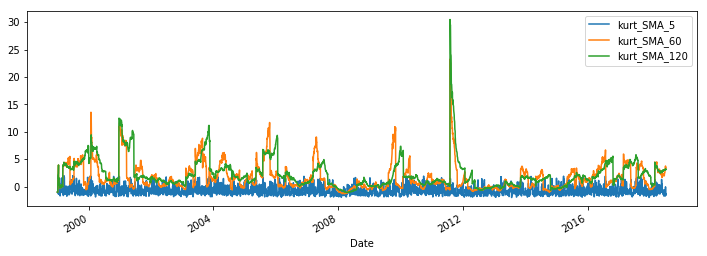

In [56]:
add_technical(df).set_index('Date')[['kurt_SMA_5', 'kurt_SMA_60', 'kurt_SMA_120']].plot()

In [57]:
add_technical(df).keys()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ch', 'Ch2', 'Ch3',
       'Ch4', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120', 'sigma2_SMA_5',
       'sigma2_SMA_20', 'sigma2_SMA_60', 'sigma2_SMA_120', 'skew_SMA_5',
       'skew_SMA_20', 'skew_SMA_60', 'skew_SMA_120', 'kurt_SMA_5',
       'kurt_SMA_20', 'kurt_SMA_60', 'kurt_SMA_120', 'Support_5', 'Support_20',
       'Support_60', 'Support_120', 'Resistance_5', 'Resistance_20',
       'Resistance_60', 'Resistance_120'],
      dtype='object')

## Files in input/.../train

In [59]:
df = pd.read_feather('input/Quandl/Sharadar/train_0/AAON.feather')
df = clean_sharadar(df)
df = add_changes(df)
df = add_technical(df)
df = df.drop(['Dividends', 'Closeunadj', 'Lastupdated'], axis=1)
df.keys()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ch', 'Ch2', 'Ch3',
       'Ch4', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120', 'sigma2_SMA_5',
       'sigma2_SMA_20', 'sigma2_SMA_60', 'sigma2_SMA_120', 'skew_SMA_5',
       'skew_SMA_20', 'skew_SMA_60', 'skew_SMA_120', 'kurt_SMA_5',
       'kurt_SMA_20', 'kurt_SMA_60', 'kurt_SMA_120', 'Support_5', 'Support_20',
       'Support_60', 'Support_120', 'Resistance_5', 'Resistance_20',
       'Resistance_60', 'Resistance_120'],
      dtype='object')

In [60]:
def transform_data(old_dir, new_dir):
    fnames = os.listdir(old_dir)
    
    for f in fnames:
        df = pd.read_feather(os.path.join(old_dir, f))
        df = clean_sharadar(df)
        df = add_changes(df)
        df = add_technical(df)
        df = df.drop(['Dividends', 'Closeunadj', 'Lastupdated'], axis=1)
        df.reset_index(drop=True).to_feather(os.path.join(new_dir, f))

In [61]:
transform_data('input/Quandl/Sharadar/train_0/', 
               'input/Quandl/Sharadar/train/')

//anaconda/envs/trend/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [62]:
transform_data('input/Quandl/Sharadar/dev_0/', 
               'input/Quandl/Sharadar/dev/')

//anaconda/envs/trend/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
transform_data('input/Quandl/Sharadar/test_0/', 
               'input/Quandl/Sharadar/test/')

//anaconda/envs/trend/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# End